# Iris dataset - Regressão Logística - 3 classes

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

<img src='../figures/RegressaoSoftmax_CrossEntropy_Otimizacao.png',width=700></img>

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

from IPython import display

## Leitura, normalização e visualização dos dados

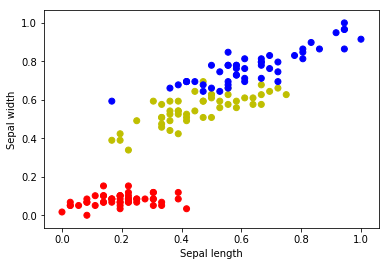

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

## Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

## Construindo o modelo da rede

<img src='../figures/RegressaoLogisticaRede_2_3.png',width=400></a>

In [4]:
model = nn.Linear(2,3)

### Fazendo um predict

In [5]:
out = model(Variable(X_tensor.narrow(0,0,4))) # 4 amostras: índice 0 a menor que 4
out

Variable containing:
-0.0319 -0.2025 -0.0221
-0.0402 -0.2209 -0.0086
-0.0400 -0.2325  0.0005
-0.0611 -0.2553  0.0160
[torch.FloatTensor of size 4x3]

## Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

In [6]:
sm = nn.Softmax()
sm(out)*100

Variable containing:
 35.0508  29.5520  35.3972
 34.8828  29.1151  36.0021
 34.8897  28.7801  36.3303
 34.4395  28.3610  37.1995
[torch.FloatTensor of size 4x3]

## Parâmetros para o treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## Classe para visualização dinâmica

In [22]:
def predict(inputs, operation):
    outputs = operation(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

def predict_prob(inputs, operation):
    outputs = operation(Variable(inputs))
    outputs = nn.functional.softmax(outputs)
    predicts, _ = torch.max(outputs, 1)
    
    return predicts.data.numpy()

class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, show_prob=False, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.show_prob = show_prob
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        
    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            
            if epoch%250==0:
                
                plt.subplot(121)
                plt.plot(np.arange(epoch+1), self.loss_hist, 'xb', linewidth = 2.0)
                
                plt.subplot(122)
                if self.show_prob:
                    Z = predict_prob(torch.from_numpy(self.X_grid).type(torch.FloatTensor), self.model)
                else:
                    Z = predict(torch.from_numpy(self.X_grid).type(torch.FloatTensor), self.model)
                    
                Z = Z.reshape(self.xx.shape)
                
                plt.figure(1, figsize=(4, 3))
                plt.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.magma)
                
                colors = np.array(['r','y','b'])
                plt.scatter(self.X[:, 0], self.X[:, 1], s=400, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(plt.gcf())
                display.clear_output(wait=True)

## Laço principal de treinamento da Regressão Logística por Softmax

Final loss: 0.13944217562675476


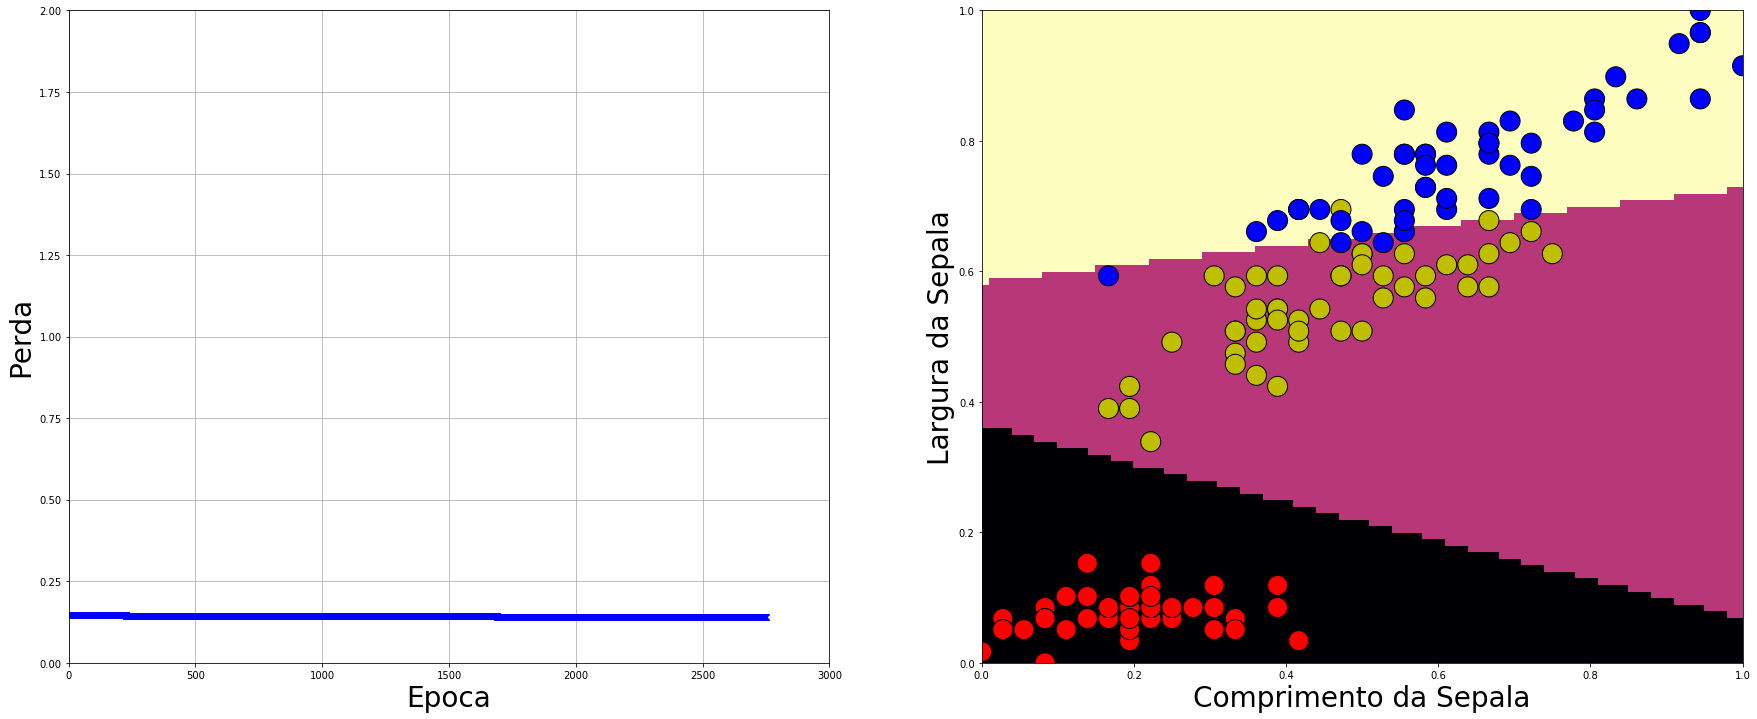

In [26]:
nb_epoch = 3000
show_prob = False

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch, show_prob=show_prob)

#Gráficos a serem mostrados pelo callback
ploss = 2.0
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
#plt.plot(0.0,ploss)
plt.ylim(0.0, ploss)
plt.xlim(0, nb_epoch)
plt.xlabel('Epoca',fontsize=28)
plt.ylabel('Perda',fontsize=28)
plt.plot(-1,-1,'b', linewidth = 2.0,label = "Treino")
plt.grid(True)

plt.subplot(122)
plt.xlim(Xc[:,0].min(), Xc[:,0].max())
plt.ylim(Xc[:,1].min(), Xc[:,1].max())
plt.xlabel('Comprimento da Sepala',fontsize=28)
plt.ylabel('Largura da Sepala',fontsize=28)

n = Xc.shape[0] # number of training examples


losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data[0])
    
    boundary_plot.on_epoch_end(i, {'loss': loss.data[0]})
    
print('Final loss:', loss.data[0])

## Imprimindo pesos finais

In [ ]:
model.state_dict()

## Salvando os pesos treinados

In [ ]:
os.makedirs('../../models',exist_ok=True)
torch.save(model.state_dict(),'../../models/RegrLog_Iris.pt')

In [ ]:
nn.init.constant(model.weight,0)

## Recuperando os pesos salvos

In [ ]:
param_saved = torch.load('../../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)

## Avaliação do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [ ]:
Y_pred = predict(X_tensor, model)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

## Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_pred, Y)

## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

### Exercícios:

1. Experimente refazer o treinamento com diferentes valores de learning rate
2. Modifique o gráfico para mostrar a probabilidade da classe predita

## Principais aprendizados